# Detecting Outliers Using LOWESS

In [4]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import STL

sns.set_context('talk')

## Load Data

In [5]:
with open('./data/27-bulk_loaded_BDG690XU_202302031452_202302031549.json') as f:
    d = json.load(f)

df_ = pd.json_normalize(d)
df = df_.copy(deep=True)
df = df.rename(columns={"attributes.adc1":"adc", 'attributes.battery':'battery', 'attributes.power':'power','attributes.totalDistance':'totalDistance'}, errors='raise')
df['deviceTime'] = pd.to_datetime(df['deviceTime'])
df = df.set_index('deviceTime')
len(df)
df = df.loc[(df['adc'] >= 1540) & (df['adc'] <= 3460)]
#df.info()
#df

### Plot the Data

<AxesSubplot: xlabel='deviceTime'>

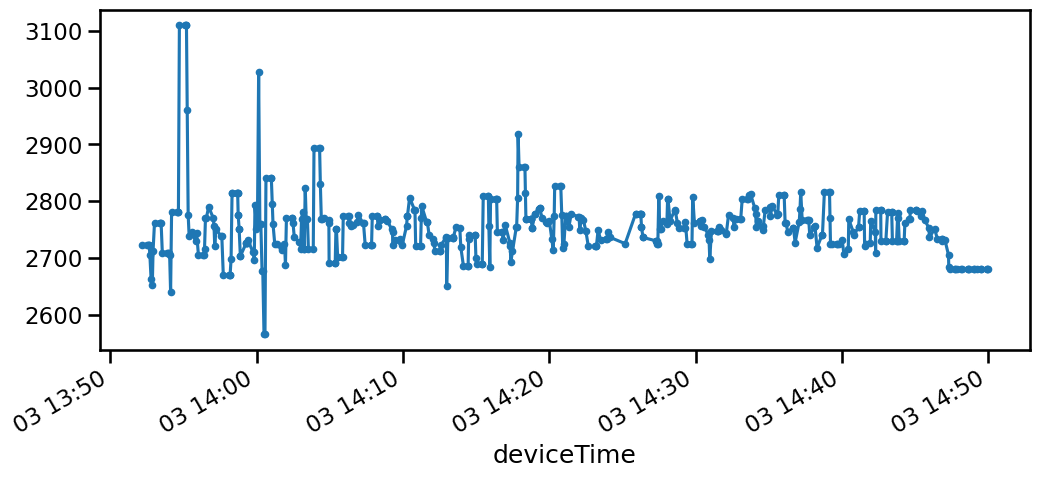

In [27]:
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="adc", marker=".", figsize=[12, 5], legend=None, ax=ax)
# ax.set_title("Retail Sales with outliers")
# ax.set_ylabel("Retail Sales")
# ax.set_xlabel("Time")

In [7]:
df_ = df.copy()

### Fit a trend line using LOWESS and examine residuals

Text(0.5, 0, 'Time')

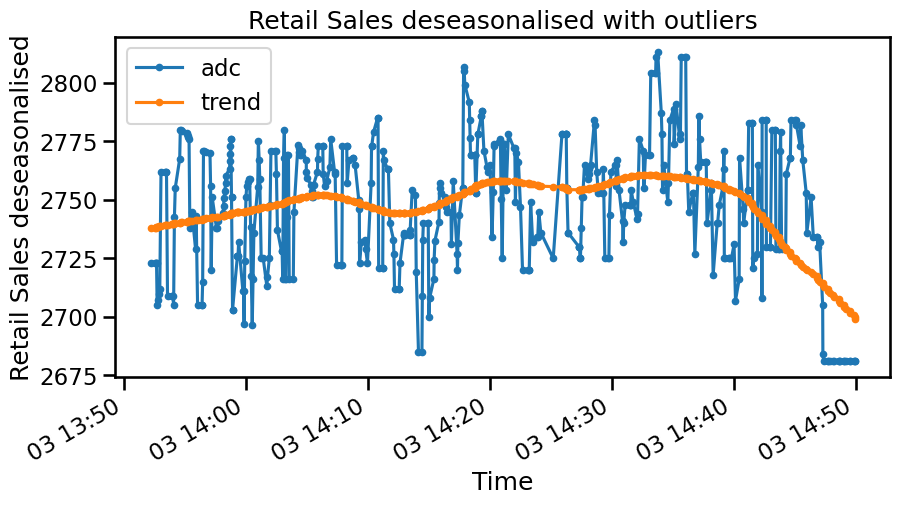

In [37]:
y = df_["adc"].values
# The x-values must be numbers rather than dates to fit the LOWESS model.
x = np.arange(0, len(y), 1)
trend = lowess(y, x, frac=0.3)
df_["trend"] = trend[:, 1]

ax = df_.plot(y=["adc", "trend"], marker=".", figsize=[10, 5])
ax.set_title("Retail Sales deseasonalised with outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("Time")

In [33]:
# Compute residuals
df_["residual"] = df_["adc"] - df_["trend"]

# Compute inter-quartile range
Q1 = df_["residual"].quantile(0.25)
Q3 = df_["residual"].quantile(0.75)
IQR = Q3 - Q1

# Apply 1.5 IQR as a threshold to identify outliers
factor = 1.5
df_["lower"] = Q1 - factor * IQR
df_["upper"] = Q3 + factor * IQR
df_["is_outlier"] = (df_["residual"] < df_["lower"]) | (
    df_["residual"] > df_["upper"]
)

df_.head()

,id,deviceId,type,protocol,serverTime,fixTime,outdated,valid,latitude,longitude,...,attributes.odometer,attributes.distance,totalDistance,attributes.hours,trend,residual,lower,upper,is_outlier,y
deviceTime,,,,,,,,,,,,,,,,,,,,,
2023-02-03 13:52:10+00:00,380522221,458,None,teltonika,2023-02-03T14:27:29.533+00:00,2023-02-03T13:52:10.000+00:00,False,True,6.444155,3.376803,...,11925964,1794.17,12012194.93,3062693390,2716.165004,6.834996,-64.588252,63.322137,False,NaN
2023-02-03 13:52:31+00:00,380501389,458,None,teltonika,2023-02-03T13:54:04.106+00:00,2023-02-03T13:52:31.000+00:00,False,True,6.443923,3.377207,...,11925964,58.87,12000833.16,3062714390,2717.789539,5.210461,-64.588252,63.322137,False,NaN
2023-02-03 13:52:34+00:00,380501390,458,None,teltonika,2023-02-03T13:54:04.106+00:00,2023-02-03T13:52:34.000+00:00,False,True,6.443887,3.377280,...,11925964,9.09,12000842.25,3062717390,2719.410233,3.589767,-64.588252,63.322137,False,NaN
2023-02-03 13:52:37+00:00,380501391,458,None,teltonika,2023-02-03T13:54:04.106+00:00,2023-02-03T13:52:37.000+00:00,False,True,6.443865,3.377328,...,11925964,5.86,12000848.11,3062720390,2721.025189,1.974811,-64.588252,63.322137,False,NaN
2023-02-03 13:52:39+00:00,380501392,458,None,teltonika,2023-02-03T13:54:04.106+00:00,2023-02-03T13:52:39.000+00:00,False,True,6.443827,3.377402,...,11925964,9.16,12000857.27,3062722390,2722.632088,0.367912,-64.588252,63.322137,False,NaN


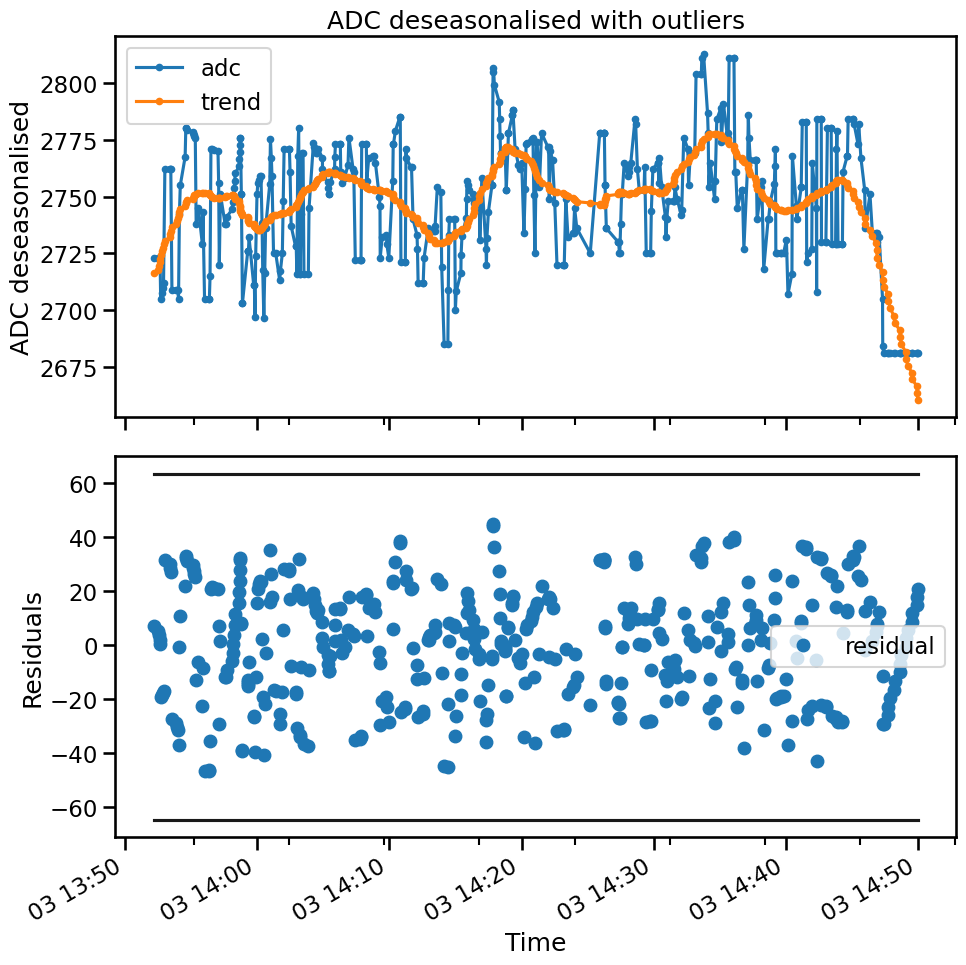

In [34]:
# Plot time series
fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharex=True)
df_.plot(y=["adc", "trend"], marker=".", ax=ax[0])
df_["residual"] = df_["residual"]

# Plot residuals
df_.plot(y=["residual"], ax=ax[1], marker="o", linestyle="")
df_.plot(y=["upper", "lower"], ax=ax[1], color="k", legend=None, alpha=0.9)

# If any data points are identified as an outlier, plot them
if df_["is_outlier"].any():
    df_["adc"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5
    )
    df_["residual"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax[1], legend=None, linestyle=""
    )

ax[0].set_title("ADC deseasonalised with outliers")
ax[0].set_ylabel("ADC deseasonalised")
ax[1].set_ylabel("Residuals")
ax[1].set_xlabel("Time")
plt.tight_layout()

We can also visualise the residuals for outliers using a histogram and box plot. This also allows us to check that the data is approximately normal.

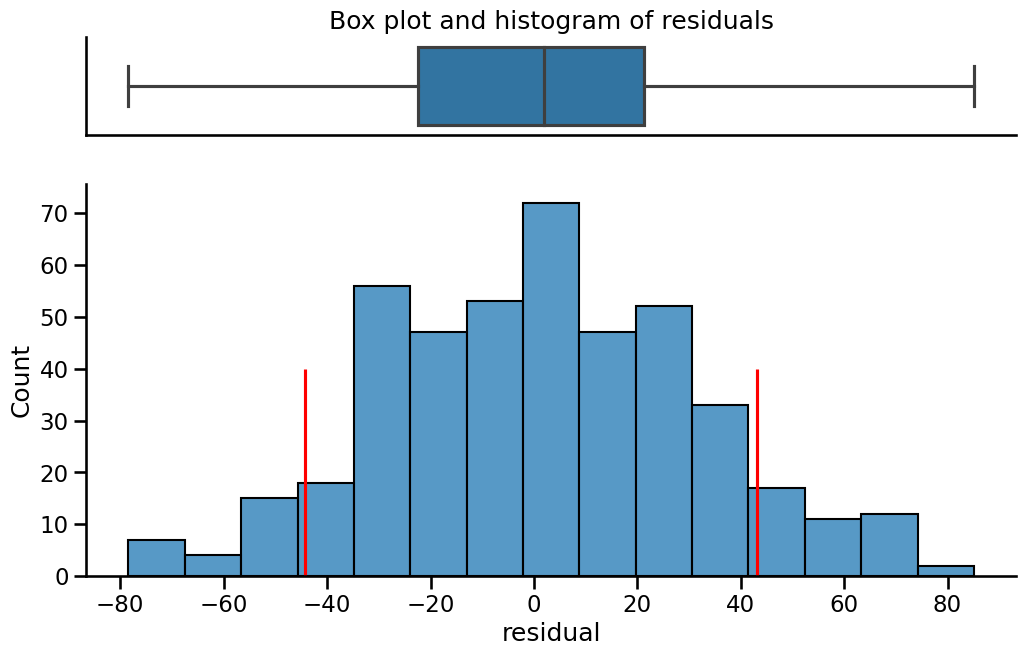

In [18]:
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}, figsize=[12, 7]
)
sns.boxplot(x=df_["residual"], ax=ax_box)
sns.histplot(x=df_["residual"], ax=ax_hist)

ax_box.axes.get_xaxis().set_visible(False)
ax_box.axes.get_yaxis().set_visible(False)
ax_box.set_title('Box plot and histogram of residuals')
    
ax_hist.vlines(Q1 - factor * IQR, 0, 40, color="r")
ax_hist.vlines(Q3 + factor * IQR, 0, 40, color="r")
sns.despine()
plt.show()

As we can see the residual method is much more sensitive and identified even smaller flucatuations in the data. The outliers are much clearer in the residual plot. To make the methods less sensitive, a simple solution would be to adjust threshold.

# Removing the outliers

Once the outliers are identified and a choice is made to remove them they can be imputed using missing value methods or using the values from the estimation methods. 

As an example we shall use linear interpolation.

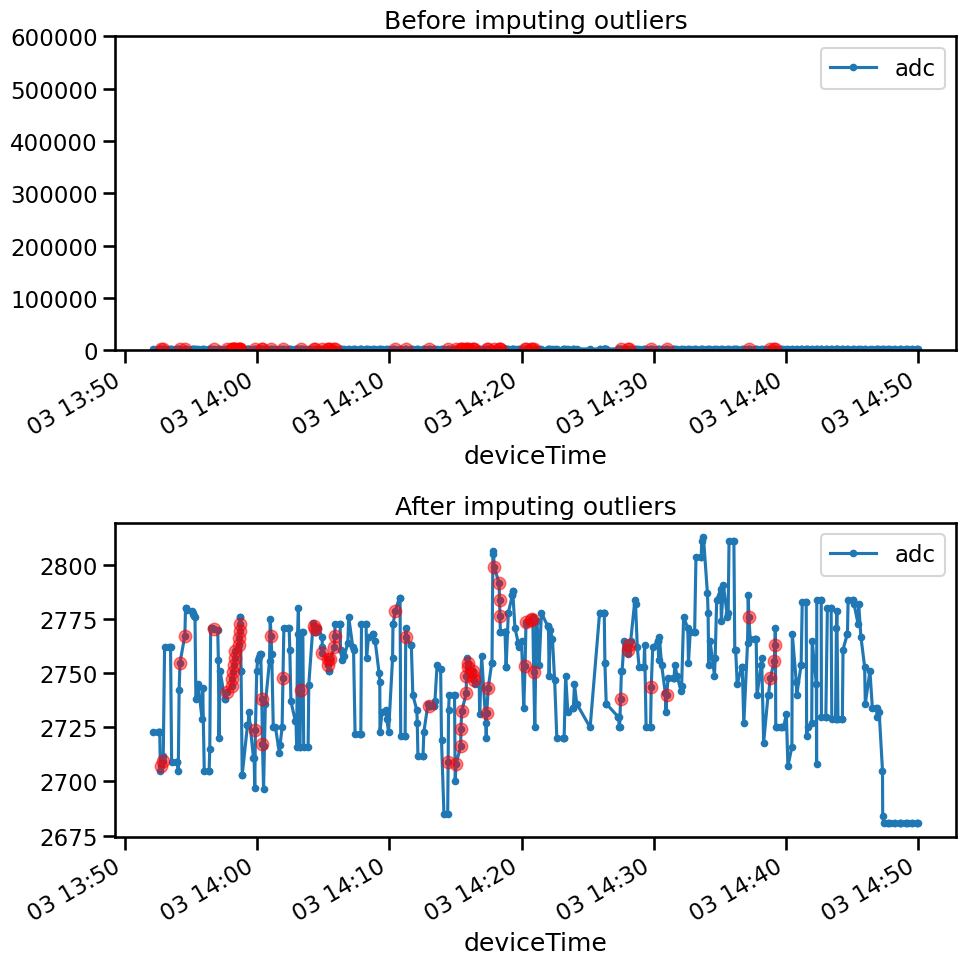

In [19]:
# Set outliers to NaN
df_.loc[df_["is_outlier"], "adc"] = np.NaN

# Apply linear interpolation
df_.interpolate(method="linear", inplace=True)

# Add the seasonality extracted from STL back to deseasoned data
# df_["adc"] = df_["adc"] + res.seasonal

# Plot the data and location of the identified outliers from the rolling median method
fig, ax = plt.subplots(nrows=2, figsize=[10, 10])
df.plot(y="adc", marker=".", title="Before imputing outliers", ax=ax[0])
df_[df_["is_outlier"]]["adc"].plot(
    marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5
)
df_.plot(y=["adc"], marker=".", title="After imputing outliers", ax=ax[1])
df_[df_["is_outlier"]]["adc"].plot(
    marker="o", color="r", ax=ax[1], legend=None, linestyle="", alpha=0.5
)
ax[0].set_ylim([0, 600000])
plt.tight_layout()